In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge import Rouge
import torch
import pandas as pd
from lexical_diversity import lex_div as ld
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math
import numpy as np
from scipy.spatial.distance import cosine

In [30]:
model_name = 'declare-lab/flan-alpaca-large'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.config.output_attentions = True

In [31]:
def get_response_and_scores(prompt, reference):

    inputs = tokenizer.encode(prompt + tokenizer.eos_token, return_tensors="pt")
    attention_mask = torch.ones(inputs.shape, dtype=torch.long)  # Create attention mask
    outputs = model.generate(inputs, attention_mask=attention_mask, max_length=50, num_return_sequences=1, temperature=0.7)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    input_ids = tokenizer.encode(response, return_tensors='pt')
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        
    loss = outputs.loss
    perplexity = torch.exp(loss)

    rouge = Rouge()
    scores = rouge.get_scores(response, reference)

    words = response.split()
    mtld_score = ld.mtld(words)

    response_length = len(response)

    df = pd.DataFrame({
        'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
        'Recall': [scores[0]['rouge-1']['r'], scores[0]['rouge-2']['r'], scores[0]['rouge-l']['r']],
        'Precision': [scores[0]['rouge-1']['p'], scores[0]['rouge-2']['p'], scores[0]['rouge-l']['p']],
        'F1 Score': [scores[0]['rouge-1']['f'], scores[0]['rouge-2']['f'], scores[0]['rouge-l']['f']],
    })

    print(f'ROUGE scores\n{df}')

    return response, perplexity.item(), scores, mtld_score, response_length

In [176]:
new_prompt = "Explain how transformer architecures work in AI"

In [177]:
reference_text = "Sports, spanning from traditional games like football and tennis to emerging fields like eSports, involve strategic, psychological, nutritional, and physical aspects, and they play a significant role in international unity, technological advancement, scientific understanding, and personal development."
response, perplexity, rouge_scores, mtld, response_length = get_response_and_scores(new_prompt, reference_text)
print('\nResponse:', response)
print('Perplexity:', perplexity)
print('MTLD:', mtld)
print('Response length:', response_length)

ROUGE scores
    Metric    Recall  Precision  F1 Score
0  ROUGE-1  0.060606   0.071429  0.065574
1  ROUGE-2  0.000000   0.000000  0.000000
2  ROUGE-L  0.060606   0.071429  0.065574

Response: Transformer architectures are a type of AI architecture that enables computers to perform tasks that would normally require human intelligence. These architectures are used to create a system that can perform tasks that would normally require human intelligence, such as recognizing
Perplexity: 1.4593102931976318
MTLD: 41.0
Response length: 282


In [6]:
def visualize_attention(prompt, response):
    # Encode the prompt and response
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")
    
    # Get the attention weights from the model
    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()  # Taking last layer's attention weights
    
    # Average attention weights across all heads
    attention_weights_avg = np.mean(attention_weights, axis=0)
    
    # Visualize averaged attention weights
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.matshow(attention_weights_avg, cmap='viridis')
    
    src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
    
    ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
    ax.set_yticklabels([''] + tgt_tokens, fontsize=6)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.title(f'Averaged Attention Map Flan-Alpaca (Baseline)')
    plt.colorbar(cax)
    plt.show()

In [164]:
response = response.split(".")[0] + "."

In [ ]:
visualize_attention(new_prompt, response)

In [173]:
def visualize_attention_per_head(prompt, response):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")

    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()

    num_heads = attention_weights.shape[0]
    

    grid_size = int(math.ceil(math.sqrt(num_heads)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axs = axs.ravel()  

    for head in range(num_heads):
        cax = axs[head].matshow(attention_weights[head], cmap='viridis')
        
        src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
        tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
        
        axs[head].set_xticks(range(len(src_tokens)))
        axs[head].set_yticks(range(len(tgt_tokens)))
        axs[head].set_xticklabels(src_tokens, rotation=90, fontsize=6)
        axs[head].set_yticklabels(tgt_tokens, fontsize=6)
        axs[head].set_title(f'Flan-Alpaca Head {head+1} (RPP)')
        fig.colorbar(cax, ax=axs[head], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
    fig.savefig('attention_heads_rpp_alpaca.png', dpi=300)

In [ ]:
visualize_attention_per_head(new_prompt, response)

In [175]:
def visualize_bar_attention_for_token(prompt, response, token_of_interest):
    
    # Encode the prompt and response
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")
    
    # Get the attention weights from the model
    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()  # Taking last layer's attention weights
    
    # Find index of the token of interest
    token_index = input_ids[0].tolist().index(tokenizer.encode(token_of_interest, add_special_tokens=False)[0])
    
    # Extract attention weights for the token of interest
    attention_for_token = attention_weights[:, token_index, :]
    
    # Average attention weights across all heads
    attention_weights_avg = np.mean(attention_for_token, axis=0)
    
    # Tokens in the response
    tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
    
    # Plot bar chart
    plt.figure(figsize=(12,6))
    plt.bar(tgt_tokens, attention_weights_avg)
    plt.xticks(rotation=90, fontsize=10)
    plt.ylabel('Attention Weight', fontsize=12)
    plt.title(f'Averaged Attention Weights for Token "{token_of_interest}"', fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_bar_attention_for_token(new_prompt, response, "Imagine")

# Prompts self attention

In [135]:
check_tokens = tokenizer.tokenize("'s'")
print(check_tokens)

['▁', "'", 's', "'"]


In [165]:
def merge_tokens_for_display(tokens):
    """Merge specific tokens for display."""
    merged_tokens = []
    i = 0
    while i < len(tokens):
        # If current token is 'x' and the next one is 'y'
        if i < len(tokens) - 2 and tokens[i] == '▁Cho' and tokens[i+1] == 'm' and tokens[i+2] == 'sky':
            merged_tokens.append('Chomsky')
            i += 3
        elif i < len(tokens) - 3 and tokens[i] == '▁' and tokens[i+1] == 'ling' and tokens[i+2] == 'u' and tokens[i+3] == 'ist':
            merged_tokens.append('linguist')
            i += 4
        else:
            # remove the "▁" for other tokens and append
            token = tokens[i]
            if token.startswith('▁'):
                token = token[1:]
            if token and token != "_":  # Only add non-empty tokens and not "_"
                merged_tokens.append(token)
            i += 1
    return merged_tokens

def visualize_encoder_self_attention(prompt):
    # Encode the prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    # Create dummy decoder input to satisfy the model's requirements
    dummy_decoder_input = torch.zeros_like(input_ids)
    
    # Get the attention weights from the model
    outputs = model(input_ids, decoder_input_ids=dummy_decoder_input, output_attentions=True)
    attention_weights = outputs.encoder_attentions[-1][0].squeeze().cpu().detach().numpy()  # Taking last layer's attention weights
    
    # Average attention weights across all heads
    attention_weights_avg = np.mean(attention_weights, axis=0)
    
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.matshow(attention_weights_avg, cmap='viridis')
    
    src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    src_tokens = merge_tokens_for_display(src_tokens)
    
    ax.set_xticks(range(len(src_tokens)))
    ax.set_yticks(range(len(src_tokens)))
    ax.set_xticklabels(src_tokens, rotation=90, fontsize=6)
    ax.set_yticklabels(src_tokens, fontsize=6)
    
    plt.title(f'Averaged Encoder Self-Attention Map')
    plt.colorbar(cax)
    plt.show()


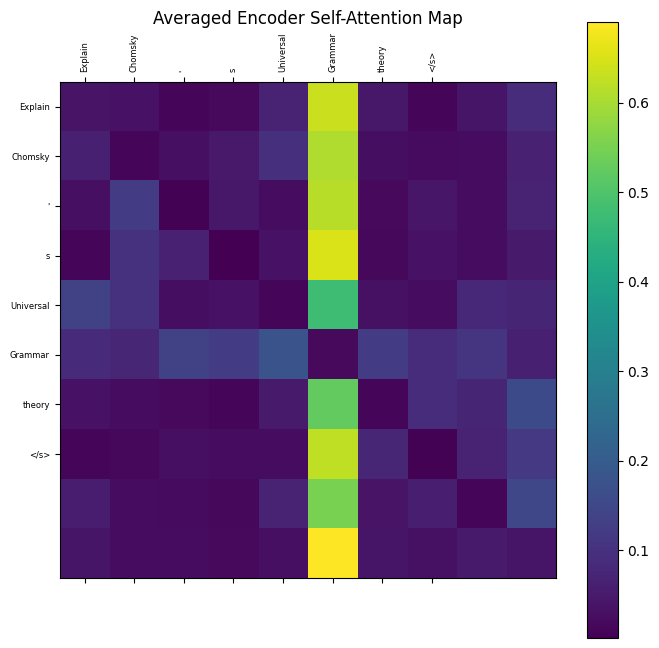

In [166]:
visualize_encoder_self_attention(new_prompt)

In [168]:
def merge_tokens_for_display(tokens):
    """Merge specific tokens for display."""
    merged_tokens = []
    i = 0
    while i < len(tokens):
        # If current token is 'x' and the next one is 'y'
        if i < len(tokens) - 2 and tokens[i] == '▁Cho' and tokens[i+1] == 'm' and tokens[i+2] == 'sky':
            merged_tokens.append('Chomsky')
            i += 3
        elif i < len(tokens) - 3 and tokens[i] == '▁' and tokens[i+1] == 'ling' and tokens[i+2] == 'u' and tokens[i+3] == 'ist':
            merged_tokens.append('linguist')
            i += 4
        else:
            # remove the "▁" for other tokens and append
            token = tokens[i]
            if token.startswith('▁'):
                token = token[1:]
            if token and token != "_":  # Only add non-empty tokens and not "_"
                merged_tokens.append(token)
            i += 1
    return merged_tokens

def visualize_encoder_self_attention_per_head_modified(prompt):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    # Create dummy decoder input to satisfy the model's requirements
    dummy_decoder_input = torch.zeros_like(input_ids)
    
    outputs = model(input_ids, decoder_input_ids=dummy_decoder_input, output_attentions=True)
    attention_weights = outputs.encoder_attentions[-1][0].squeeze().cpu().detach().numpy()

    src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    src_tokens = merge_tokens_for_display(src_tokens)

    num_heads = attention_weights.shape[0]
    
    grid_size = int(math.ceil(math.sqrt(num_heads)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axs = axs.ravel()

    for head in range(num_heads):
        cax = axs[head].matshow(attention_weights[head, :len(src_tokens), :len(src_tokens)], cmap='viridis')
        
        axs[head].set_xticks(range(len(src_tokens)))
        axs[head].set_yticks(range(len(src_tokens)))
        axs[head].set_xticklabels(src_tokens, rotation=90, fontsize=6)
        axs[head].set_yticklabels(src_tokens, fontsize=6)
        axs[head].set_title(f'Head {head+1} Encoder Self-Attention')
        fig.colorbar(cax, ax=axs[head], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
    fig.savefig('alpaca_encoder_self_attention_heads_sip_4.png', dpi=300)

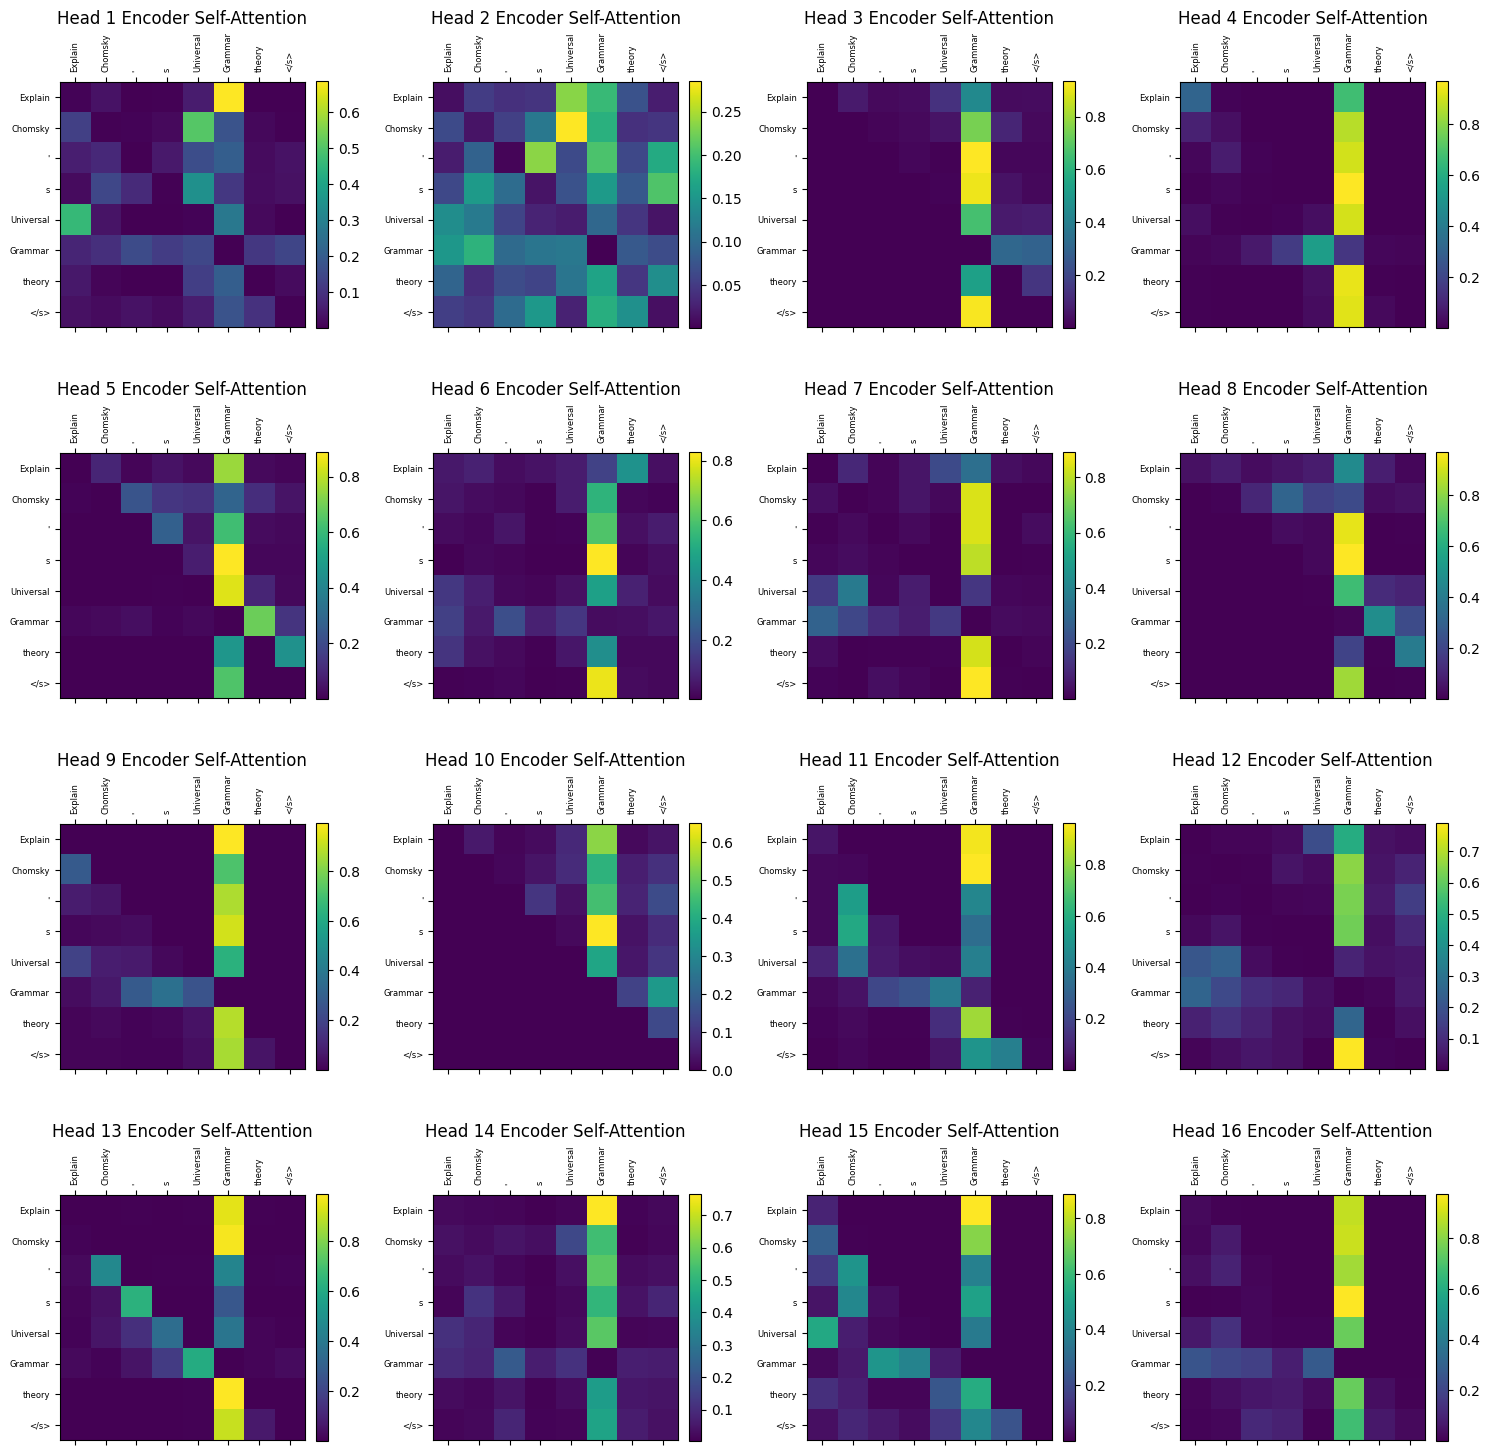

In [169]:
visualize_encoder_self_attention_per_head_modified(new_prompt)

In [178]:
def calculate_entropy(p):
    p = p[p > 0]  # Filter zero probabilities to avoid log(0)
    return -np.sum(p * np.log(p))

def calculate_cosine_similarity(A, B):
    A_flat = A.flatten()
    B_flat = B.flatten()
    return 1 - cosine(A_flat, B_flat)

input_ids = tokenizer.encode(new_prompt, return_tensors="pt")
response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")
outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy() 
#[-1] index used to select the attention weights from the last decoder layer
#[0] index used to select the attention weights of all heads from that layer
normalized_attention_weights = attention_weights / attention_weights.sum(axis=1, keepdims=True)


In [179]:
# Calculate entropy for each token's attention distribution
entropies = [calculate_entropy(row) for row in normalized_attention_weights]
print(f"Entropies: {entropies}")

# Example: Calculate cosine similarity between attention distributions of the first and second tokens
similarity = calculate_cosine_similarity(normalized_attention_weights[0], normalized_attention_weights[1])
print(f"Cosine Similarity between Token 1 and Token 2: {similarity}")

Entropies: [67.38847, 54.25432, 56.69784, 67.124146, 71.03975, 75.55588, 46.459553, 106.553696, 85.438614, 98.38399, 115.527985, 65.740036, 59.247547, 51.46583, 91.38546, 92.655945]
Cosine Similarity between Token 1 and Token 2: 0.7363433837890625


In [192]:
entropies_rpp = [53.64961334, 56.3775164, 53.36472233, 66.74996994, 69.37049625, 83.38986694, 45.28745296, 94.99456421,	
                 83.68739479, 94.57284569, 107.3210827, 64.3021487, 58.26721638, 49.63643093, 80.88592171, 101.6019245]


entropies_sip = [52.94056221, 54.12350712, 51.30320885, 65.74549339, 68.23240181, 81.64066574, 44.70910053,	
                 92.20499878, 81.54507729, 90.92525162, 105.42675, 62.27857147, 57.85365562, 48.95370415, 78.40151756, 97.26055084]



def get_entropy_difference(rp_entropy, si_entropy):
    return [i - j for i, j in zip(rp_entropy, si_entropy)]

difs = get_entropy_difference(entropies, entropies_sip)
print(difs)

[-1.3818730925683624, -2.045923807011718, 1.0327744263671903, -0.9474968690038992, -1.6032285311914052, -3.4222666921484404, -2.61116580709961, -3.461041260468747, -0.2754697460546822, -6.560085909550779, -3.950691040039061, -7.438880307890628, -0.5285060838671853, -1.8399002864746095, -3.8933846254296895, 2.4097372459375066]


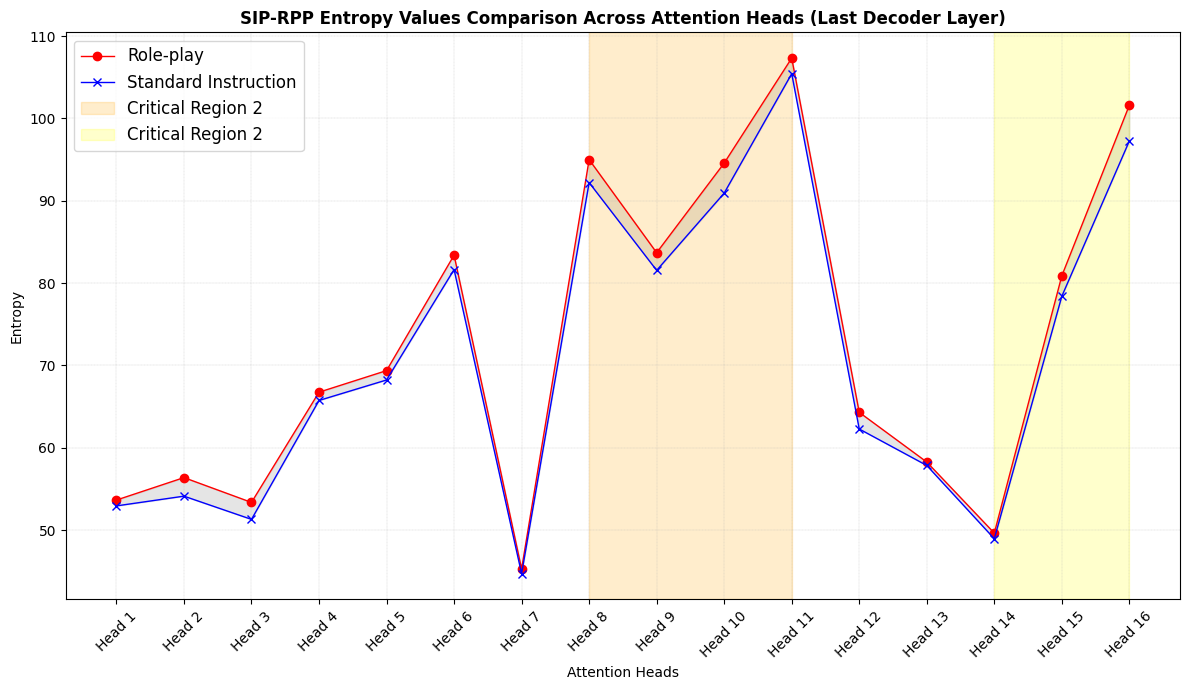

In [194]:
fig, ax = plt.subplots(figsize=(12, 7))

plt.fill_between(range(len(entropies_rpp)), entropies_rpp, entropies_sip, color='gray', alpha=0.2)

plt.plot(entropies_rpp, marker='o', linestyle='-', color='red', label='Role-play', linewidth=1)
plt.plot(entropies_sip, marker='x', linestyle='-', color='blue', label='Standard Instruction', linewidth=1)
plt.axvspan(7, 10, color='orange', alpha=0.2, label='Critical Region 2')
plt.axvspan(13, 15, color='yellow', alpha=0.2, label='Critical Region 2')

plt.xlabel('Attention Heads')
plt.ylabel('Entropy')
plt.title('SIP-RPP Entropy Values Comparison Across Attention Heads (Last Decoder Layer)', fontsize=12, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.legend(fontsize=12, loc='upper left')
plt.xticks(ticks=range(len(entropies)), labels=[f"Head {i+1}" for i in range(len(entropies))], rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

fig.savefig('entropy_values_comparison_4.png', dpi=300)

In [190]:
import pandas as pd

# Load the Excel file
df = pd.read_excel("/Users/inigoparra/Desktop/PE-LE/datasets/entropies_code_rpp.xlsx")

# Function to calculate entropy and cosine similarity for a given prompt
def compute_entropy_and_single_similarity(prompt):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    # Generate response
    outputs = model.generate(input_ids, max_length=50, num_return_sequences=1, temperature=0.7)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")

    # Get attention weights
    model_outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = model_outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()
    normalized_attention_weights = attention_weights / attention_weights.sum(axis=1, keepdims=True)

    # Calculate entropy for each token's attention distribution
    entropies = [calculate_entropy(row) for row in normalized_attention_weights]

    # Calculate cosine similarity between attention distributions of the first and second tokens
    similarity = calculate_cosine_similarity(normalized_attention_weights[0], normalized_attention_weights[1])
    
    return entropies, similarity

# Loop through all prompts and calculate entropy and cosine similarities
all_entropies = []
all_single_similarities = []

for prompt in df['Prompts']:
    entropies, single_similarity = compute_entropy_and_single_similarity(prompt)
    all_entropies.append(entropies)
    all_single_similarities.append(single_similarity)

In [191]:
# Convert entropies list to a DataFrame
entropy_df = pd.DataFrame(all_entropies, columns=[f'Head_{i+1}_Entropy' for i in range(len(all_entropies[0]))])

# Add the entropies and cosine similarities to the original DataFrame
df = pd.concat([df, entropy_df], axis=1)
df['Cosine_Similarity'] = all_single_similarities

# Save the updated DataFrame to an Excel file
df.to_excel("/Users/inigoparra/Desktop/PE-LE/datasets/entropies_code_rpp_updated.xlsx", index=False)
